<a href="https://colab.research.google.com/github/RK22000/SVIC/blob/main/Scotty2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and initial stuff

In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

from tqdm import tqdm

from zipfile import ZipFile

from os import listdir

import pandas as pd

import matplotlib.pyplot as plt



In [2]:
base_path = '/content/data/IDC_regular_ps50_idx5'

# Download data

roughly 1 minute 30 sec to run all

In [2]:
!mkdir /root/.kaggle

In [3]:
!cp /content/drive/Shareddrives/cancerClassify_ML@SJSU/kaggle.json /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [02:18<00:00, 21.0MB/s]
100% 3.10G/3.10G [02:18<00:00, 24.1MB/s]


In [5]:

with ZipFile('/content/breast-histopathology-images.zip', 'r') as zipObj:
    zipObj.extractall("data")

In [6]:

len(listdir('data'))

280

IDC_regular_ps50_idx5 is the same data but all the images are regularized to be 50x50

I think


In [8]:


images  = []
targets = []
pids    = []


base_path = '/content/data/IDC_regular_ps50_idx5'
patients = listdir(base_path)
for pat in tqdm(patients):
    for c in [0, 1]:
        fold = f'{base_path}/{pat}/{c}/'
        imgs = listdir(fold)
        images += [fold + img for img in imgs]
        targets += [c]*len(imgs)
        pids += [pat]*len(imgs)
len(images), len(targets), len(pids)

100%|██████████| 279/279 [00:00<00:00, 1356.47it/s]


(277524, 277524, 277524)

In [9]:


df = pd.DataFrame({
    'Patient': pids,
    'Image': images,
    'Target': targets
})
df.sample(10)

,Patient,Image,Target
15901,12909,/content/data/IDC_regular_ps50_idx5/12909/1/12...,1
35265,12823,/content/data/IDC_regular_ps50_idx5/12823/1/12...,1
233742,12878,/content/data/IDC_regular_ps50_idx5/12878/0/12...,0
209894,16551,/content/data/IDC_regular_ps50_idx5/16551/0/16...,0
48753,14156,/content/data/IDC_regular_ps50_idx5/14156/0/14...,0
181920,14155,/content/data/IDC_regular_ps50_idx5/14155/0/14...,0
185922,12906,/content/data/IDC_regular_ps50_idx5/12906/1/12...,1
122808,12951,/content/data/IDC_regular_ps50_idx5/12951/0/12...,0
152543,12821,/content/data/IDC_regular_ps50_idx5/12821/0/12...,0
116824,12818,/content/data/IDC_regular_ps50_idx5/12818/1/12...,1


# Dataset Exploration

Text(0.5, 1.0, 'Cancerous vs Benign samples')

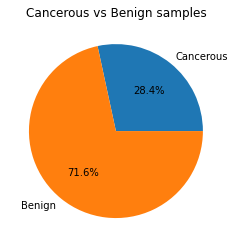

In [ ]:
neg, pos = len(df[df.Target==0]), len(df[df.Target==1])
plt.pie([pos, neg], labels=["Cancerous", "Benign"], autopct='%1.1f%%')
plt.title("Cancerous vs Benign samples")

In [ ]:
tmp = df[['Patient', 'Target']]
grp = tmp.groupby(by='Patient')
tmp = grp.sum()
tmp['Total'] = grp.count()['Target']
tmp.head()

,Target,Total
Patient,,
10253,70,549
10254,76,848
10255,91,272
10256,117,468
10257,208,635


# Dataset

In [3]:

def show_img(img):
    plt.imshow(T.ToPILImage()(img))

In [4]:
class BC_Dataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.images  = []
        self.targets = []
        self.pids    = []
        base_path = root
        patients = listdir(base_path)
        for pat in tqdm(patients):
            for c in [0, 1]:
                fold = f'{base_path}/{pat}/{c}/'
                imgs = listdir(fold)
                self.images += [fold + img for img in imgs]
                self.targets += [c]*len(imgs)
                self.pids += [pat]*len(imgs)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = read_image(self.images[idx])
        label = self.targets[idx]
        if torch.cuda.is_available():
            image = image.to('cuda')
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.float()/255, label

In [5]:
full_set = BC_Dataset(base_path, transform=T.Resize((50,50)))

100%|██████████| 279/279 [00:00<00:00, 1393.49it/s]


In [6]:
full_set[0]

(tensor([[[0.4392, 0.2392, 0.3216,  ..., 0.9569, 0.9569, 0.9529],
          [0.3529, 0.1255, 0.2941,  ..., 0.9569, 0.9569, 0.9569],
          [0.4706, 0.4588, 0.6431,  ..., 0.9569, 0.9569, 0.9569],
          ...,
          [0.7373, 0.5294, 0.8314,  ..., 0.8196, 0.7412, 0.6706],
          [0.6706, 0.6275, 0.8588,  ..., 0.8353, 0.8157, 0.5529],
          [0.8902, 0.8627, 0.8471,  ..., 0.7804, 0.8863, 0.7961]],
 
         [[0.4118, 0.3765, 0.4196,  ..., 0.9529, 0.9490, 0.9490],
          [0.2824, 0.3333, 0.4431,  ..., 0.9490, 0.9490, 0.9490],
          [0.4549, 0.5373, 0.7412,  ..., 0.9490, 0.9490, 0.9490],
          ...,
          [0.2000, 0.2000, 0.4667,  ..., 0.7529, 0.5608, 0.3843],
          [0.3686, 0.2118, 0.5725,  ..., 0.6667, 0.7451, 0.3961],
          [0.7608, 0.6980, 0.5529,  ..., 0.6863, 0.8706, 0.7098]],
 
         [[0.5216, 0.5647, 0.6078,  ..., 0.9529, 0.9529, 0.9529],
          [0.4314, 0.5804, 0.6353,  ..., 0.9529, 0.9529, 0.9529],
          [0.5961, 0.6980, 0.8392,  ...,

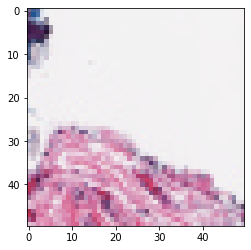

In [7]:
show_img(full_set[0][0])

In [9]:

train_set, test_set, _ = random_split(
    full_set, 
    [
        10_000,#int(0.7*len(full_set)), 
        10_000,#int(0.2*len(full_set)), 
        len(full_set)-20_000#len(full_set)-int(0.7*len(full_set))-int(0.2*len(full_set))
    ], 
    generator=torch.Generator(device="cpu").manual_seed(42)
)
[len(_set) for _set in [train_set, test_set]]

[10000, 10000]

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:


train_dataloader = DataLoader(train_set, batch_size=50, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_dataloader = DataLoader(test_set, batch_size=50, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

# CNN

In [12]:
ip = torch.rand(3, 50, 50)
convo = nn.Conv2d(3, 24, 3)
rel = nn.ReLU()
pool = nn.MaxPool2d(4)
convo(ip).size(), rel(convo(ip)).size(), pool(rel(convo(ip))).size()

(torch.Size([24, 48, 48]), torch.Size([24, 48, 48]), torch.Size([24, 12, 12]))

In [13]:
stk = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
stk(ip).size()

torch.Size([64, 4, 4])

In [14]:
64*4*4

1024

In [15]:
class BC_Classifier(nn.Module):
    def __init__(self):
        super(BC_Classifier, self).__init__()
        self.convo_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*4*4, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
        )

    def forward(self, x):
        x = self.convo_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [16]:
model = BC_Classifier().to(device)
print(model)

BC_Classifier(
  (convo_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [17]:
X = torch.rand(5, 3, 50, 50, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1, 1, 1, 1, 1], device='cuda:0')


# Training

## Helper functions

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Training

In [22]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-8
optimizer = torch.optim.Adam(model.parameters()) #torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.741381  [    0/10000]
loss: 0.430160  [ 5000/10000]


100%|██████████| 200/200 [00:04<00:00, 44.80it/s]

Test Error: 
 Accuracy: 81.9%, Avg loss: 0.413599 

Done!


# Save and Load model

In [23]:
model_file = '/content/drive/Shareddrives/cancerClassify_ML@SJSU/models/simpleCNN10mini.pth'

In [24]:
torch.save(model, model_file)

In [26]:
model = torch.load(model_file)

In [25]:
test_loop(test_dataloader, model, nn.CrossEntropyLoss())

100%|██████████| 200/200 [00:04<00:00, 44.35it/s]

Test Error: 
 Accuracy: 81.9%, Avg loss: 0.413599 



# SVC attempt

In [26]:
half_pass = lambda x: model.linear_relu_stack[:3](
    model.flatten(
        model.convo_stack(x)
    )
).to('cpu').numpy()

In [27]:
device

'cuda'

In [28]:
with torch.no_grad():
    print(half_pass(torch.rand(5, 3, 50, 50).to(device)).shape)

(5, 10)


In [29]:
import numpy as np
class Dset:
    def __init__(self, x=[], y=[]):
        self.x = x
        self.y = y

In [30]:
len(test_set), len(train_set)

(10000, 10000)

In [31]:
from math import ceil

with torch.no_grad():
    X, y = [], []
    for _x, _y in tqdm(test_dataloader):
        X.extend(half_pass(_x))
        y.extend(_y.to('cpu'))
        #print(len(X))
    test = Dset(np.array(X), np.array(y))
    print("Test dset")
    print(test.x.shape, test.y.shape)

    X, y = [], []
    for _x, _y in tqdm(train_dataloader):
        X.extend(half_pass(_x))
        y.extend(_y.to('cpu'))
    train = Dset(np.array(X), np.array(y))
    print("Train dset")
    print(train.x.shape, train.y.shape)



100%|██████████| 200/200 [00:04<00:00, 44.54it/s]


Test dset
(10000, 10) (10000,)


100%|██████████| 200/200 [00:04<00:00, 44.09it/s]

Train dset
(10000, 10) (10000,)


In [32]:
test.x.shape, test.y.shape

((10000, 10), (10000,))

In [33]:
sum(train.y[:1000])

286

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [38]:
size = 10000
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(train.x[:size], train.y[:size])
clf.score(test.x, test.y)

0.8283